**Imports**

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec, lines, legend_handler
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as scs
from statsmodels.formula.api import ols
from os import path
from io import StringIO
from IPython.display import display
import PIL
from tqdm.notebook import tqdm

from python_scripts.utils import loc_utils as lut
from python_scripts.utils import vis_utils as vut
from python_scripts.utils.vis_utils import gcolors, glabels, fullglabels, gmarkers, colors, ncolors, tlabels
from python_scripts.utils.model_utils import get_baseline_aic, softmax_1d

plt.style.use('python_scripts/my.mplstyle')

# Figure 1

In [ ]:
def subfig_1a(ax, data_path):
    img = PIL.Image.open(data_path)
    img.load(scale=5)
    ax.imshow(img)
    
    
def subfig_1b(ax, data_path):
    # Load data
    columns = ['sid','group','trial','rpc1','rpc2','rpc3','rpc4']
    df = pd.read_csv(data_path).filter(items=columns)
    # Select PC values for last trial of familiarization
    df = df.loc[df.trial.eq(60), :].drop(columns='trial')
    # Convert to long format
    df = pd.wide_to_long(df, stubnames='rpc', i=['sid','group'], j='activity').reset_index()
    df.sort_values(by=['group','sid'], inplace=True)
#     display(df.head())
    # Convert to percentages
    df['percent_correct'] = df.rpc * 100
    # Plot
    sns.boxplot(x='activity', y='percent_correct', hue='group', data=df,
                saturation=1, palette=sns.set_palette(sns.color_palette(gcolors)), ax=ax)
    props = {'connectionstyle': 'bar',
             'arrowstyle': '-',
             'patchA': None, 'patchB': None,
             'shrinkA': 10, 'shrinkB': 10,
             'linewidth': 2}
    bh, pad = 100, .025
    for i in range(3):
        ax.text(x=i + .5, y=bh + 15, s='***', fontsize=15, ha='center', va='top')
        ax.annotate('', xy=(i + pad, bh), xytext=(i + 1 - pad, bh), xycoords='data',
                    ha='center', va='top', arrowprops=props)
    ax.set_ylim(0, 115)
    ax.set_xlim(-.5, 3.8)
    ax.set_xlabel('Learning activity')
    ax.set_ylabel('% correct')
    ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontweight='bold')
    for xt, c in zip(ax.get_xticklabels(), colors):
        xt.set_color(c)
    # Add legend
    ax.legend_.remove()
    ax.text(3.5, 100, glabels[0], va='top', ha='left',
            fontsize=15, fontweight='bold', color=gcolors[0])
    ax.text(3.5, 80, glabels[1], va='bottom', ha='left',
            fontsize=15, fontweight='bold', color=gcolors[1])


def make_fig1(figname, save_to, save_as=''):
    fig = plt.figure(figname, figsize=[11, 10])
    gs = fig.add_gridspec(ncols=4, nrows=2, 
                          width_ratios=[.1,1,2,1],
                          height_ratios=[2, 1.2])
    
    # Subplot (a)
    vut.add_subplot_label(x=0, y=.9, label='a', size=20, ax=fig.add_subplot(gs[0, 0]))
    ax_a = fig.add_subplot(gs[0, 1:])
    vut.ghostify(ax_a)
    subfig_1a(ax_a, 'images/fig1a.eps')
   
    # Subplot (b)
    vut.add_subplot_label(x=0, y=1, label='b', size=20, ax=fig.add_subplot(gs[1, 0]))
    ax_b = vut.pretty(fig.add_subplot(gs[1, 2]), 'y')
    subfig_1b(ax_b, 'data/heuristics_data.csv')

    # Save figure
    fig.tight_layout()
    fig.subplots_adjust(hspace=.05)
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=150)
        
        
make_fig1(
    figname='figure1',
    save_to='figures',
    save_as='png' # File format (png, jpeg, svg, ...)
)

# Figure 2

In [ ]:
def subfig_2a(axes, data_path, ghost_axis):
    # Load data, select columns
    df = pd.read_csv(data_path)[['sid','group','trial','activity']]
    # Select free-play trials
    df = df.loc[df.trial.le(60+250) & df.trial.gt(60), :]
    df.loc[:, 'trial'] -= 60
    # Get group sizes
    group_sizes = [group_sids.size for group_sids in df.groupby(['group']).sid.unique().values]
    # Count subjects per activity per trial for each group
    df = df.groupby(['group','activity','trial']).agg({'sid': 'nunique'})
    df = df.rename(columns={'sid':'n'})
    # Create ghost axis for common label
    vut.ghostify(ghost_axis)
    ghost_axis.set_ylabel('Fraction of Ps selecting a learning activity', labelpad=30)
    # Plot data
    for i, grp in enumerate([0, 1]):
        ax = axes[i]
        ax.set_xlim(1, 250)
        ax.set_ylim(.08, .5)
        ax.grid(True)
        if i:
            ax.set_xlabel('Trial')
        else:
            ax.tick_params(labelbottom=False)
            handles = [lines.Line2D([0], [0], color=colors[k], ls='', marker='o', label=tlabels[k + 1]) for k in range(4)]
            leg = ax.legend(handles, tlabels.values(), handletextpad=.05,
                            bbox_to_anchor=(0, 1, 1, 0.2), loc='lower left', mode='expand', ncol=4)
            vut.color_legend(leg)
        txt = ax.text(x=.05, y=.95, s=fullglabels[grp],
                      ha='left', va='top', transform=ax.transAxes,
                      color=gcolors[grp], fontweight='bold', fontsize=20)

        for j, activity in enumerate(df.index.unique(1).tolist()):
            psel = df.loc[(grp, activity, slice(None)), 'n'].sort_index().values / group_sizes[grp]
            ax.plot(psel, c=colors[j], label=activity, lw=3)


def subfig_2b(ax, data_path):
    # Load data
    df = pd.read_csv(data_path)
    df = df.replace({'group': {0: 'IG', 1: 'EG'}})
    df = df.loc[df.nam.gt(0), :]
    # Plot data
    sns.histplot(
        df, x='dwfpc', hue='group', element='step',
        stat='probability', common_norm=True, bins=15, ax=ax,
        palette=sns.set_palette(sns.color_palette(gcolors)), legend=True,
        linewidth=3
    )
    ax.set_ylabel('Frequency')
    ax.set_xlabel('dwfPC')
    # Add legend
    legend = ax.get_legend()
    legend.set_title('')
    legend.set_bbox_to_anchor([.1, .65, .2, .3])


def make_fig2(figname, save_to, save_as=''):
    fig = plt.figure(figname, figsize=[10, 6])
    gs = fig.add_gridspec(ncols=4, nrows=6, 
                          width_ratios=[.3,1,.3,1],
                          height_ratios=[1,1,1,1,1,1])
    
    # Subplot (a)
    vut.add_subplot_label(x=0, y=1.1, label='a', size=20, ax=fig.add_subplot(gs[0, 0]))
    ghost_axis = fig.add_subplot(gs[:, 1])
    axes = [vut.pretty(fig.add_subplot(gs[i, 1])) for i in [slice(0, 3), slice(3, 6)]]
    subfig_2a(axes, 'data/clean_data.csv', ghost_axis)
   
    # Subplot (b)
    vut.add_subplot_label(x=0, y=1.1, label='b', size=20, ax=fig.add_subplot(gs[0, 2]))
    ax_b = vut.pretty(fig.add_subplot(gs[1:5, 3]), 'y')
    subfig_2b(ax_b, 'data/learning_data.csv')

    # Save figure
    fig.tight_layout()
    fig.subplots_adjust(wspace=.1)
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)
        
        
make_fig2(
    figname='figure2',
    save_to='figures',
    save_as='png' # File format (png, jpeg, svg, ...)
)

# Figure 3

See related analyses in /R_scripts/dwfpc_by_grp-NAM.R

In [ ]:
def subfig_3a(ax, data_path):
    # Load data
    df = pd.read_csv(data_path)
    df = df.loc[df.nam > 0, :]
    # Get counts and relative frequencies within groups
    df = df.groupby(['group','nam'])[['sid']].agg('count').rename(columns={'sid':'count'}).reset_index()
    df['group_count'] = df.groupby('group').transform('sum').loc[:, 'count']
    df['rf'] = df.loc[:, 'count'] / df.loc[:, 'group_count']
    df = df.replace({'group':{0: 'IG', 1: 'EG'}})
    # Plot
    sns.barplot(
        x='nam', y='rf', hue='group', data=df, ax=ax, saturation=1,
        palette=sns.set_palette(sns.color_palette(gcolors))
    )
    ax.set_ylabel('Frequency')
    ax.set_xlabel(None)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['\nNAM\n{}'.format(nam) for nam in [1,2,3]])
    ax.get_legend().set_title(None)
    vut.change_width(ax, .3)


def subfig_3b(axes, data_path, nam_data_path):
    # Load data
    df = pd.read_csv(data_path).filter(items=['sid','group','trial','activity'])
    # Select only required free-play trials (N = 250)
    df = df.loc[df.trial.le(60+250) & df.trial.gt(60), :]
    nam_df = pd.read_csv(nam_data_path).filter(items=['sid','nam','mp3']).set_index('sid')
    df = df.dropna().drop(columns='trial')
    df = df.merge(nam_df.drop(columns='mp3'), on='sid')
    df = df.loc[df.nam.gt(0), :]
    # Count trials per activity for each subject
    counts = df.groupby(['group', 'nam', 'sid']).activity.value_counts().to_frame('counts')
    counts = 100*counts / counts.groupby(['group', 'nam', 'sid']).transform('sum')
    counts_stats = counts.groupby(['group','nam','activity']).agg(['mean', 'sem'])
    counts_stats.columns = counts_stats.columns.droplevel(0)
    # Plot
    for nam in [1, 2, 3]:
        ax = axes[nam-1]
        ax.axhline(25, ls='--', color='k', alpha=.8)
        x = np.array([1, 2, 3, 4])
        for i, group in enumerate([0, 1]):
            x_ = x+[-.1, .1][group]
            y = counts_stats.loc[(group, nam, slice(None)), 'mean']
            yerr = counts_stats.loc[(group, nam, slice(None)), 'sem']
            ax.errorbar(x_, y, yerr=yerr, color=gcolors[group], marker=gmarkers[group],
                        capsize=5, markersize=8, lw=2, label=fullglabels[group])
        ax.set_ylim(10, 57)
        ax.set_xticks(x)
        ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontweight='bold')
        for xt, c in zip(ax.get_xticklabels(), colors):
            xt.set_color(c)
        if nam == 1:
            ax.set_ylabel('Trials per activity\n(%; Mean and SEM)')
        if nam == 2:
            ax.set_xlabel('Learning activity'.format(nam))
        if nam > 1:
            ax.tick_params(labelleft=False)
    leg = axes[1].legend(loc='upper center', ncol=2)


def subfig_3c(ax, data_path):
    df = pd.read_csv(data_path)
    df = df.loc[df.nam > 0, :]
    bins = np.arange(0, 1.02, .1)
    nam_labels = ['NAM ' + str(i) for i in (1, 2, 3)]

    for nam in [1, 2, 3]:
        for group in [0, 1]:
            y = df.loc[df.nam.eq(nam) & df.group.eq(group), 'dwfpc']
            rf, _ = np.histogram(y, bins=bins, weights=np.ones_like(y) / y.size)
            ax.plot(
                bins[1:], rf, c=ncolors[nam - 1], lw=2,
                ls='-' if group else '--', marker='o',
            )
    ax.set_xlim(0.4, 1.02)
    # Edit legend
    c = 'darkgray'
    legmark = lambda x: lines.Line2D([0], [0], ls='', marker='o', markerfacecolor=ncolors[x], markeredgecolor=ncolors[x])
    legline = lambda x: lines.Line2D([0], [0], color=c, lw=2, ls=['-','--'][x], label=fullglabels[x])
    nam_leg = [legmark(n) for n in [0, 1, 2]]
    grp_leg = [legline(g) for g in [0, 1]]
    leg_labs = nam_labels + list(fullglabels.values())
    ax.legend(
        nam_leg + grp_leg, leg_labs,
        bbox_to_anchor=(.5, .87,),
        loc='center', ncol=5,
        handler_map={tuple: legend_handler.HandlerTuple(ndivide=None)}
    )
    ax.set_ylim(0, .6)
    ax.set_xlabel('dwfPC')
    ax.set_ylabel('Frequeny')


def make_fig3(figname, save_to, save_as=''):
    fig = plt.figure(figname, figsize=[8.2, 9])
    gs = fig.add_gridspec(ncols=4, nrows=3,
                          width_ratios=[.5,1,1,1],
                          height_ratios=[1,1,1.5])
    labx, laby = 0, 1.1

    # Subplot (a)
    vut.add_subplot_label(x=labx, y=laby, label='a', size=20, ax=fig.add_subplot(gs[0, 0]))
    ax_a = vut.pretty(fig.add_subplot(gs[0, 1:]))
    subfig_3a(ax_a, 'data/learning_data.csv')

    # Subplot (b)
    vut.add_subplot_label(x=labx, y=laby, label='b', size=20, ax=fig.add_subplot(gs[1, 0]))
    axes_b = [vut.pretty(fig.add_subplot(gs[1, i+1]), 'y') for i in range(3)]
    subfig_3b(axes_b, 'data/clean_data.csv', 'data/nam_data.csv')

    # Subplot (c)
    vut.add_subplot_label(x=labx, y=laby, label='c', size=20, ax=fig.add_subplot(gs[2, 0]))
    ax_c = vut.pretty(fig.add_subplot(gs[2, 1:]))
    subfig_3c(ax_c, 'data/learning_data.csv')

    # Save figure
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)


make_fig3(
    figname='figure3',
    save_to='figures',
    save_as='png' # File format (png, jpeg, svg, ...)
)


# Figure 4

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0.627879,0.036819,0.555437,0.700320,0.396662,0.859096
1,0.634414,0.035384,0.564796,0.704032,0.404066,0.864762
2,0.640808,0.033981,0.573950,0.707666,0.411279,0.870337
3,0.647061,0.032611,0.582898,0.711223,0.418302,0.875819
4,0.653172,0.031273,0.591640,0.714703,0.425137,0.881206


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dwfpc   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     14.15
Date:                Sat, 09 Jan 2021   Prob (F-statistic):           1.25e-10
Time:                        21:53:49   Log-Likelihood:                 250.17
No. Observations:                 320   AIC:                            -490.3
Df Residuals:                     315   BIC:                            -471.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5619      0.038     14.783      0.000       0.487       0.637
dwipc                   0.3256      0.059      5.553      0.000       0.210       0.441
group                   0.0228      0.013      1.745      0.082      -0.003       0.048
sc_lep                 -0.0054      0.007     -0.822      0.412      -0.018       0.007
np.power(sc_lep, 2)    -0.0226      0.005     -4.679      0.000      -0.032      -0.013
==============================================================================
Omnibus:                        7.602   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.849
Skew:                          -0.371   Prob(JB):                       0.0198
Kurtosis:                       2.802   Cond. No.                         21.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Delta AIC = -19.51


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 sc_lep   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     6.206
Date:                Sat, 09 Jan 2021   Prob (F-statistic):           1.67e-05
Time:                        21:53:49   Log-Likelihood:                -438.98
No. Observations:                 320   AIC:                             890.0
Df Residuals:                     314   BIC:                             912.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.3455      0.168     -2.061      0.040      -0.675      -0.016
C(group)[T.1]                 0.6858      0.253      2.716      0.007       0.189       1.183
C(nam)[T.2]                  -0.1162      0.206     -0.565      0.573      -0.521       0.289
C(nam)[T.3]                   0.3372      0.215      1.567      0.118      -0.086       0.761
C(group)[T.1]:C(nam)[T.2]     0.0739      0.307      0.241      0.810      -0.530       0.678
C(group)[T.1]:C(nam)[T.3]    -0.4958      0.304     -1.630      0.104      -1.094       0.103
==============================================================================
Omnibus:                        0.439   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.803   Jarque-Bera (JB):                0.556
Skew:                           0.072   Prob(JB):                        0.757
Kurtosis:                       2.854   Cond. No.                         13.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

group  nam
0      1      33
       2      65
       3      51
1      1      26
       2      57
       3      88
Name: sid, dtype: int64

/Users/alexten/Projects/Humans-monitor-LP/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


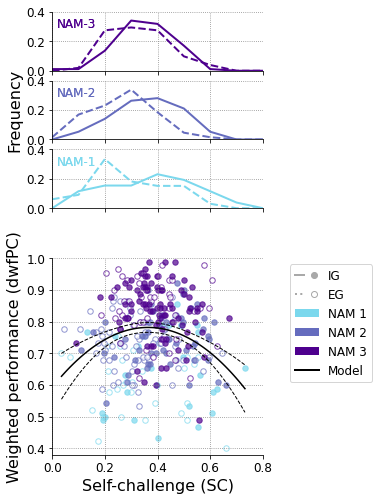

In [3]:
def make_fig4(data_path, figname, save_to, save_as=''):
    df = pd.read_csv(data_path)
    df = df.loc[df.nam > 0, :]

    propS = np.sum(df.group == 1) / df.shape[0]

    fig = plt.figure(figname, figsize=[5.5, 7])
    gs = gridspec.GridSpec(2, 1)

    # Make figure (scatter plot and histograms)
    ghost_top = fig.add_subplot(gs[0, 0])
    ghost_top.set_ylabel('Frequency', labelpad=30)
    ghost_top.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    for spine in ghost_top.spines.values(): spine.set_visible(False)

    ax_top1 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=9, borderpad=0))
    ax_top2 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=10, borderpad=0))
    ax_top3 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=8, borderpad=0))

    ax_scat = vut.pretty(fig.add_subplot(gs[1, 0]))

    bins = np.arange(0, 1.02, .1)
    labels = {'nam': ['NAM ' + str(i) for i in (1, 2, 3)], 'group': fullglabels}
    axes_by_nam = {
        'top': {
            3: ax_top1,
            2: ax_top2,
            1: ax_top3}}
    for nam in [1, 2, 3]:
        axes_by_nam['top'][nam].set_xlim(.0, .8)
        axes_by_nam['top'][nam].set_ylim(0., .4)
        for group in [0, 1]:
            x = df.loc[(df.nam == nam) & (df.group == group), 'sc_lep']
            y = df.loc[(df.nam == nam) & (df.group == group), 'dwfpc']
            ax_scat.scatter(x, y, s=30, alpha=.7,
                            facecolors=ncolors[nam - 1] if group else 'w',
                            edgecolors=ncolors[nam - 1])

            rf, _ = np.histogram(x, bins=bins, weights=np.ones_like(x) / x.size)
            axes_by_nam['top'][nam].plot(bins[:-1], rf, c=ncolors[nam - 1], lw=2,
                                         ls='-' if group else '--',
                                         label='{} / NAM-{}'.format(glabels[group], nam))
            axes_by_nam['top'][nam].tick_params(labelbottom=False)
            axes_by_nam['top'][nam].text(.02, .9, 'NAM-{}'.format(nam), ha='left', va='top', fontsize=12,
                                         color=ncolors[nam - 1], transform=axes_by_nam['top'][nam].transAxes)
    ax_scat.set_xlim(.0, .8)
    ax_scat.set_ylim(0.38, 1.)
    ax_scat.set_xlabel('Self-challenge (SC)')
    ax_scat.set_ylabel('Weighted performance (dwfPC)')
    
    # Add legend
    legpatch = lambda c: Patch(facecolor=c)
    legmark1 = lambda c: lines.Line2D([0], [0], ls='', marker='o', markerfacecolor=c, markeredgecolor=c)
    legmark2 = lambda c: lines.Line2D([0], [0], ls='', marker='o', markerfacecolor='w', markeredgecolor=c)
    legline1 = lambda c: lines.Line2D([0], [0], color=c, lw=2, ls='-')
    legline2 = lambda c: lines.Line2D([0], [0], color=c, lw=2, ls=':')
    nam_leg = [legpatch(c) for c in ncolors]
    c = 'darkgray'
    grp_leg = [(legline1(c), legmark1(c)), (legline2(c), legmark2(c))]
    leg_labs = list(fullglabels.values()) + labels['nam'] + ['Model']
    ax_scat.legend(
        grp_leg + nam_leg + [legline1('k')], 
        leg_labs,
        bbox_to_anchor=(1.1, 1,),
        loc='upper left', ncol=1,
        handler_map={tuple: legend_handler.HandlerTuple(ndivide=None)}
    )

    # Plot line of best fit for unstandardized data
    qreg = ols('dwfpc ~ (dwipc + {0} + np.power({0}, 2) + group)'.format('sc_lep'), data=df).fit()
    x = np.linspace(df.loc[:, 'sc_lep'].min(), df.loc[:, 'sc_lep'].max(), 100)
    y_hat = qreg.get_prediction({'sc_lep': x,
                                 'dwipc': np.full_like(x, df.dwipc.mean()),
                                 'group': np.full_like(x, propS)
                                 }).summary_frame()
    display(y_hat.head())
    c, alpha = 'k', 1
    ax_scat.plot(x, y_hat['mean'], c=c, alpha=alpha)
    ax_scat.plot(x, y_hat['mean_ci_lower'], c=c, lw=1, ls='--', alpha=alpha)
    ax_scat.plot(x, y_hat['mean_ci_upper'], c=c, lw=1, ls='--', alpha=alpha)
    
    # Run quadratic regression of final performance
    df.loc[:, 'sc_lep'] = scs.stats.zscore(df.loc[:, 'sc_lep']) # Standardize x before fitting the quadratic model
    qreg = ols('dwfpc ~ dwipc + group + sc_lep + np.power(sc_lep, 2)', data=df).fit()
    display(qreg.summary())
    
    # Run nonquadratic regression and compare AIC
    nonqreg = ols('dwfpc ~ (dwipc + sc_lep + group)', data=df).fit()
    print('Delta AIC = {:.2f}'.format(qreg.aic - nonqreg.aic))

    # Run model of average SC as a function of Group x NAM
    lreg = ols('sc_lep ~ C(group) * C(nam)', data=df).fit()
    display(lreg.summary())
    
    # Show group and subgroup counts
    display(df.groupby(['group', 'nam'])['sid'].agg('count'))
    
    # Save figure
    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=150)


make_fig4(
    data_path='data/learning_data.csv',
    figname='figure4',
    save_to='figures',
    save_as='' # File format (png, jpeg, svg, ...)
)

# Figure 5

The precise results of model comparisons differ slightly from those reported in the article because optimization algorithm used is sensitive to initial parameters set for the fitted models.


SAVED TO: figures/figure5.png


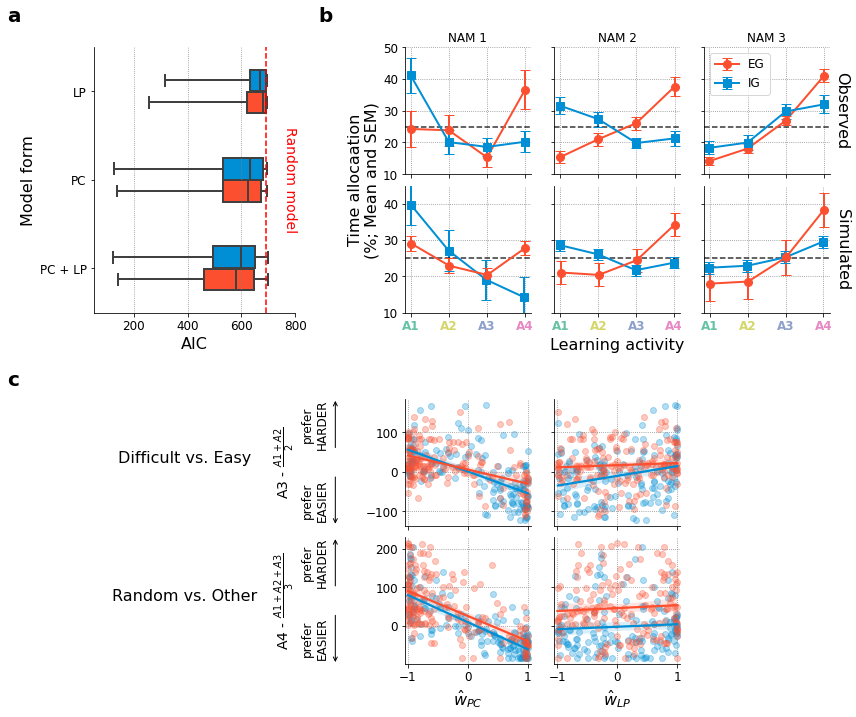

In [79]:
def subfig_5a(ax, data_path, stripplot=False):
    # Load data
    plot_df = pd.read_csv(data_path, index_col='vars').filter(items=['group','aic'])
    # Optionally, filter out model forms
    to_remove = 'abst'
    plot_df = plot_df[~plot_df.index.to_series().str.contains(to_remove)]
    # Relabel model forms
    new_ind = plot_df.index.to_series().str.replace(',',' + ')
    new_ind = new_ind.str.replace('rpc', 'PC')
    new_ind = new_ind.str.replace('rlp', 'LP')
    new_ind = new_ind.str.replace('abst','EXP')
    plot_df.index = pd.Index(new_ind, name='vars')
    # Calculate average scores per model form
    df = plot_df.groupby(['vars']).agg({'aic':['mean', 'std']})
    df.columns = df.columns.map('_'.join)
    df.sort_values(by='aic_mean', ascending=False, inplace=True)
    # Plot data
    if stripplot:
        sns.stripplot(
            x='aic', y='vars', hue='group', data=plot_df.reset_index(), ax=ax,
            dodge=True, color='k', alpha=.6, size=2, order=df.index
        )
    sns.boxplot(
        x='aic', y='vars', hue='group', data=plot_df.reset_index(), ax=ax,
        saturation=1, palette=sns.set_palette(sns.color_palette(gcolors)),
        linewidth=2, order=df.index, whis=100, width=.5
    )
    ax.legend_.remove()
    for v in ax.collections: v.set_edgecolor('w')
    # Add details
    baseline_AIC = get_baseline_aic(250, 4)
    ax.axvline(baseline_AIC, ls='--', zorder=3, color='red',
               label='Random model')
#     ax.legend().remove()
    ax.set_ylabel('Model form')
    ax.set_xlabel('AIC')
    ax.set_xlim(50, 800)
    ax.tick_params(labelsize=12)
    ax.text(780, 1, 'Random model', color='red', ha='center', va='center', rotation=-90, fontsize=14)


def subfig_5b1(axes, data_path, nam_data):
    # Load data
    df = pd.read_csv(data_path)[['sid','group','trial','activity']]
    nams = pd.read_csv(nam_data)[['sid', 'nam']]
    # Select only required free-play trials (N = 250)
    df = df.loc[df.trial <= 60+250].drop(columns='trial').merge(nams, on='sid')
    # Count trials per activity for each subject
    counts = df.groupby(['group', 'nam', 'sid']).activity.value_counts().to_frame('counts')
    counts = ((counts - 15)/250)*100
    counts_stats = counts.groupby(['group','nam','activity']).agg(['mean', 'sem'])
    counts_stats.columns = counts_stats.columns.droplevel(0)
    # Plot data
    x = np.array([1, 2, 3, 4])
    for j, nam in enumerate([1, 2, 3]):
        ax = axes[j]
        ax.axhline(25, ls='--', color='k', alpha=.8)
        for i, grp in enumerate([1, 0]):
            y = counts_stats.loc[(grp, nam, slice(None)), 'mean']
            yerr = counts_stats.loc[(grp, nam, slice(None)), 'sem']
            ax.errorbar(x, y, yerr=yerr, color=gcolors[grp], marker=gmarkers[grp],
                        capsize=5, markersize=8, lw=2, label=fullglabels[grp])
        ax.set_xticks(x)
        ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontweight='bold')
        ax.set_ylim(10, 50)
        for xt, c in zip(ax.get_xticklabels(), colors):
            xt.set_color(c)
        ax.tick_params(labelbottom=False, labelleft=False if j else True)
        # Annotate
        ax.set_title(f'NAM {nam}', fontsize=12)
        if nam == 3: 
            leg = ax.legend()
            ax.set_ylabel('Observed', rotation=-90, labelpad=20)
            ax.yaxis.set_label_position('right')



def subfig_5b2(axes, exposure_data_path, params_data_path, n_trials, n_subjects):
    # Define function to calculate PC and LP heuristics
    def get_heuristics(x):
        rpc = x.mean()
        rlp = np.abs(x[-9:].mean() - x[:10].mean())
        return rpc, rlp
    # Define the utility-based softmax choice function
    def choose(h, p):
        u = sum([i*j for i, j in zip(h, p[:-1])]) * p[-1]
        return np.random.choice([0,1,2,3], p=softmax_1d(u))
    # Get exposure data to simulate responses
    np.random.seed(1)
    exposure = pd.read_csv(exposure_data_path)
    # Load params data and choose model form
    df = pd.read_csv(params_data_path).set_index(['sid', 'vars'])
    df = df.loc[(slice(None), 'rpc,rlp'), :].drop(columns=['aic'])
    df = df.sample(n=n_subjects, replace=True, random_state=1)
    # Simulate experiment
    sim_data = []
    for i, sdf in tqdm(df.iterrows()):
        group, nam = sdf.group, sdf.nam
        nam_exp = exposure.loc[exposure.nam.eq(nam), :].drop(columns='nam').values
        # Simulate responses using actual data
        sim_resp = (np.random.uniform(0, 1, size=nam_exp.shape) < nam_exp).astype(int)
        train_resp = sim_resp[:15, :]
        # Get initial heuristic values
        rpc = train_resp.mean(axis=0)
        rlp = np.abs(train_resp[-9:, :].mean(axis=0) - train_resp[:10, :].mean(axis=0))
        abst = np.zeros(sim_resp.shape[1])
        h_array = np.array([rpc, rlp, abst]).T
        # Get subject's choice parameters
        params = sdf.loc['rpc':'tau'].fillna(0).values.squeeze()
        # Simulate free choices
        for t in range(0, n_trials):
            choice = choose(h_array.T, params)
            rpc, rlp = get_heuristics(sim_resp[t+1:t+1+15, choice])
            h_array[choice, 0] = rpc
            h_array[choice, 1] = rlp
            h_array[choice, 2] += 1
        sim_data.append([i, group, nam, *(h_array[:, 2]/n_trials)])
    # Put data into a DataFrame
    df = pd.DataFrame(sim_data, columns=['sid','group','nam','freq1','freq2','freq3','freq4'])
    x = np.array([1, 2, 3, 4])
    for i, nam in enumerate([1, 2, 3]):
        ax = axes[i]
        ax.axhline(25, ls='--', color='k', alpha=.8)
        for group in [0, 1]:
            y = df.loc[df.group.eq(group) & df.nam.eq(nam), 'freq1':'freq4']*100
            y = np.mean(y, axis=0)
            yerr = scs.sem(y, axis=0)
            x_ = x+[-.01, .01][group]
            ax.errorbar(x_, y, yerr=yerr, color=gcolors[group], marker=gmarkers[group],
                        capsize=5, markersize=8, lw=2, label=fullglabels[group])
        ax.set_ylim(10, 45)
        ax.set_xticks(x)
        ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontsize=12, fontweight='bold')
        for xt, c in zip(ax.get_xticklabels(), colors):
            xt.set_color(c)
        ax.tick_params(labelleft=False if i else True)
        if nam == 3:
            ax.set_ylabel('Simulated', rotation=-90, labelpad=20)
            ax.yaxis.set_label_position('right')


def subfig_5c(axes_dict, params_data_path, modeling_data_path, norm=True):
    # Load params data and choose model form
    df1 = pd.read_csv(params_data_path).set_index(['sid', 'vars'])
    df1 = df1.loc[(slice(None), 'rpc,rlp'), :].drop(columns=['aic'])
    df1['norm'] = np.sqrt(df1.rpc**2 + df1.rlp**2)
    # Load time choice data data
    df2 = pd.read_csv(modeling_data_path).filter(items=['sid', 'trial', 'abst1', 'abst2', 'abst3', 'abst4'])
    df2 = df2.rename(columns=dict(zip(['abst'+s for s in '1234'],['n'+s for s in '1234'])))
    df2 = df2.loc[df2.trial.eq(250), :].drop(columns='trial')
    # Merge datasets
    df = df1.merge(df2, on='sid').set_index('group')
    del df1, df2
    # Data axes
    axes = axes_dict.pop('annotation_axes')
    contrs = []
    coef_labels = {'rlp':'\hat w_{LP}', 'rpc':'\hat w_{PC}'}
    for group in [0, 1]:
        for k, ax in axes_dict.items():
            contr, coef = k.split('%')
            if contr not in contrs: 
                contrs.append(contr)
            x = df.loc[group, coef] / df.loc[group, 'norm'] if norm else df.loc[group, coef]
            terms = [[c for c in term.split(',')] for term in contr.split('-')]
            cols = [[f'n{col}' for col in term] for term in terms]
            y = df.loc[group, cols[0]].mean(axis=1) - df.loc[group, cols[1]].mean(axis=1)
            sns.regplot(
                x=x, y=y, ax=ax, color=gcolors[group],
                scatter_kws={'alpha': .3}
            )
            ax.set_xlim(-1.05, 1.05)
            if '4' in k: 
                ax.set_xlabel(r'${}$'.format(coef_labels[coef]))
            else: 
                ax.set_xlabel('')
                ax.tick_params(labelbottom=False)
            if 'rlp' in k: 
                ax.tick_params(labelleft=False)
    # Annotations
    diff_labels = {3: 'Difficult', 4: 'Random'}
    arrow_labels = {
        'prefer\nHARDER': [(1.20, 1.), (1.20, .6)],
        'prefer\nEASIER': [(1.20, 0.), (1.20, .4)],
    }
    for ax, contr in zip(axes, contrs):
        vut.ghost(ax)
        c1, c2 = [[int(j) for j in i.split(',')] for i in contr.split('-')]
        minus = 'Other' if 3 in c2 else 'Easy'
        long_desc = f'{diff_labels[c1[0]]} vs. {minus}'
        ax.text(.45, .5, long_desc, transform=ax.transAxes, fontsize=16, ha='center')
        other = '+'.join([f'A{i}' for i in c2])
        contr_label = r'$\frac{'+f'{other}'+'}{'+f'{len(c2)}'+r'}$' if len(c2) > 1 else f'{other}'
        short_desc = ' - '.join([
            f'A{c1[0]}', contr_label
        ])
        ax.text(.95, .5, short_desc, transform=ax.transAxes, fontsize=14, ha='center', va='center', rotation=90)
        for ann, xy in arrow_labels.items():
            ax.annotate(
                    '', xy=xy[0], xycoords=ax.transAxes,
                    xytext=xy[1], textcoords=ax.transAxes,
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3'),
                )
            min_, max_ = min([xy[0][1], xy[1][1]]), max([xy[0][1], xy[1][1]])
            y = min_ + (max_-min_)/2
            ax.text(xy[0][0]-.1, y, ann, transform=ax.transAxes, fontsize=12, ha='center', va='center', rotation=90)


def make_fig5(figname, save_to, save_as=''):
    fig = plt.figure(figname, figsize=[12, 10])
    gs = fig.add_gridspec(ncols=6, nrows=5,
                          width_ratios=[.5, 1.6, .5, 1, 1, 1],
                          height_ratios=[1, 1, .5, 1, 1])
    labx, laby = 0, 1.1
    
    # Subplot (a)
    vut.add_subplot_label(x=labx, y=laby+.1, label='a', size=20, ax=fig.add_subplot(gs[0, 0]))
    ax_a = vut.pretty(fig.add_subplot(gs[:2, 1]))
    subfig_5a(ax_a, 'data/model_results/param_fits_clean.csv')

    # Subplot (b)
    vut.add_subplot_label(x=labx, y=laby+.1, label='b', size=20, ax=fig.add_subplot(gs[0, 2]))
    # Create ghost axis for common labels
    ax = fig.add_subplot(gs[:2, 3:])
    vut.ghost(ax)
    ax.set_xlabel('Learning activity', labelpad=25)
    ax.set_ylabel('Time allocaation\n(%; Mean and SEM)', labelpad=25)
    # (b)-1 empirical choices
    axes_b1 = [vut.pretty(fig.add_subplot(gs[0, 3+i])) for i in range(3)]
    subfig_5b1(axes_b1, 'data/clean_data.csv', 'data/nam_data.csv')
    # (b)-2 simulated choices
    axes_b2 = [vut.pretty(fig.add_subplot(gs[1, 3+i])) for i in range(3)]
    subfig_5b2(
        axes = axes_b2,     
        exposure_data_path = 'data/exposure_data.csv',
        params_data_path = 'data/model_results/param_fits_clean.csv',
        n_trials = 250, n_subjects = 500
    )

    # Subplot (c)
    vut.add_subplot_label(x=labx, y=laby, label='c', size=20, ax=fig.add_subplot(gs[3, 0]))
    axes_c = {}
    axes_c['annotation_axes'] = [fig.add_subplot(gs[3+i, 1]) for i in range(2)]
    for i, contr in enumerate(['3-1,2', '4-1,2,3']):
        for j, coef in enumerate(['rpc', 'rlp']):
            axes_c['%'.join([contr,coef])] = vut.pretty(fig.add_subplot(gs[3+i, 3+j]))
    subfig_5c(axes_c, 'data/model_results/param_fits_clean.csv', 'data/model_data.csv', True)

    # Save figure
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2, hspace=0.1)
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)


make_fig5(
    figname='figure5',
    save_to='figures',
    save_as='png' # File format (png, jpeg, svg, ...)
)